# Project: Forecasting Italian Consumer Price Index 
## Name_Surname: Thuy Anh Tran - 31738A
## Course: Laboratory Introduction to Coding and Data Management for EPS 2023-2024

### Overall methodology
The aim of my project is to derive a time series model from historical data of **Italian Consumer price index (CPI)** on the training sample, thus forecast on hold-out sample to evaluate forecast capability of the model. 

My data set is on monthly basis in 10 years, from 01-01-2010 to 01-12-2020 from Federal Reserve Economics Data (FRED). The data set is split into train set and test set (or hold-out sample). The train set is used to find the appropriate regression model. The test set is used to fit the chosen model to forecast, then compare the forecasted CPI from the model and the actual data.

The model I use to forecast is **Seasonal Autoregressive Moving Average model (SARIMA model)**, a time series model which explains dependent variables on its own lagging values (Autoregressive) and lagging residuals (Moving Average). I use SARIMA instead of ARIMA since I recognized seasonal effect in the historical data. I will present more details in the further parts.
My project includes the key parts as the following:

 1) Summary of data trend
    
 2) Unit root test and data transformation  
 
 3) Model fitting
    
 4) Forecasting and forecast evaluation
    
 5) Conclusion
    



### 1. Summary of data trend

In [136]:
#Install statsmodels module
!pip install statsmodels

In [137]:
#Libraries used in the project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import statsmodels.api as sm


In [138]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [139]:
#Get the monthly CPI data download from FRED
cpi_data = pd.read_csv(r'C:\Users\Admin\Downloads\ITA_CPIs.csv')
cpi_data['DATE'] = pd.to_datetime(cpi_data['DATE'])
# Set the DATE as the index
cpi_data.set_index('DATE', inplace=True)
cpi_data['Formatted_Date'] = cpi_data.index.strftime('%Y-%m')
display(cpi_data)

,ITACPALTT01CTGYM,Formatted_Date
DATE,,
2010-01-01,1.306823,2010-01
2010-02-01,1.150882,2010-02
2010-03-01,1.370061,2010-03
2010-04-01,1.552742,2010-04
2010-05-01,1.387531,2010-05
...,...,...
2020-08-01,-0.530188,2020-08
2020-09-01,-0.574774,2020-09
2020-10-01,-0.311914,2020-10


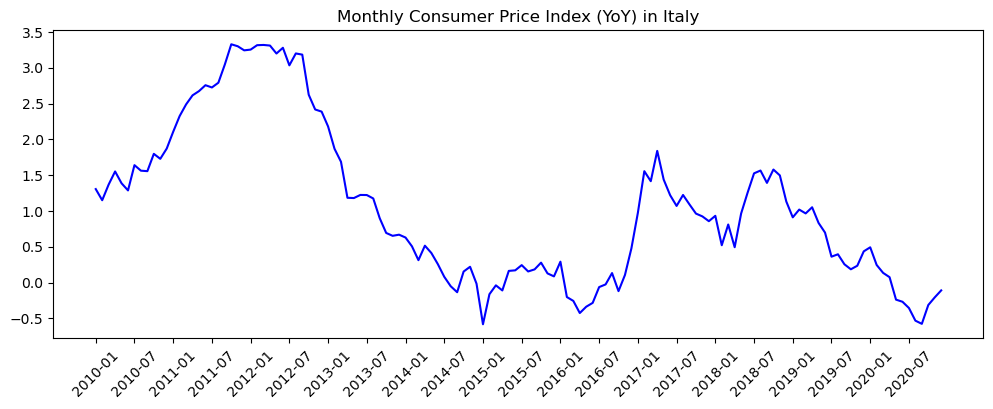

In [140]:
# Plot the CPI data
plt.figure(figsize=(12, 4))
plt.plot(cpi_data['Formatted_Date'], cpi_data['ITACPALTT01CTGYM'], label='CPI in Italy', color='blue')
plt.title('Monthly Consumer Price Index (YoY) in Italy')
plt.grid(False)
plt.xticks(ticks=range(0, len(cpi_data),6), labels=cpi_data['Formatted_Date'][::6], rotation=45)
plt.show()

### 2. Unit root test and data transformation
As we can see from the plot, there are some trends in the original data in specific periods. This signals non-stationarity in the data series. 
The presence of a unit root in a time series has significant implications for econometric analysis. If a unit root exists,it signifies that the series is non-stationary. It can lead to spurious regressions, where relationships between variables appear significant but are actually meaningless.

To implement unit root test, theoretically, Augmented Dickey-Fuller test (ADF test) is often used. The equation is:
$$Y_t = \rho Y_{t-1} + \sum_{j=1}^{p-1} \zeta_j \Delta Y_{t-j} + \epsilon_t$$
The test is designed to test the hypothesis system:
$$H_0: {\rho = 1}$$
$$H_1: {|\rho| \neq 1}$$

If the $H_0$ hypothesis is accepted, the series has unit root and we  have to transform the data to obtain stationary data series. Reversely, if the $H_0$ hypothesis is rejected, the series does not have unit root. In order to accept or reject the null hypothesis, we will look at the **ADF statistics** or the **p-value** of the ADF test result. 
In python, `adfuller` function from `statsmodels` library supports us to check unit root in the input series easily.

In [141]:
#Check unit root
# ADF test with automatic lag length selection
adf_result = adfuller(cpi_data['ITACPALTT01CTGYM'], autolag='AIC')
    
# Summary of the ADF test result
print(f'Results of Augmented Dickey-Fuller Test for CPI Italy:')
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')
print('\n')

Results of Augmented Dickey-Fuller Test for CPI Italy:
ADF Statistic: -1.2523167111775542
p-value: 0.6506955950216906
Critical Values:
   1%: -3.482087964046026
   5%: -2.8842185101614626
   10%: -2.578864381347275




From the result, we can have a look at 2 values. 
$$ADF statistic = -1.25 > Critical value = -2.88$$ at 5% significant level. 
Also, $p-value = 0.65 > 0.05$. Therefore, we accept the null hypothesis. There is unit root in the series. 
Hence, I first difference the orginal series and obtain `dcpi` series to proceed further analysis.

In [142]:
#Difference the series
dcpi = cpi_data['ITACPALTT01CTGYM'].diff(1)
display(dcpi)

DATE
2010-01-01         NaN
2010-02-01   -0.155941
2010-03-01    0.219179
2010-04-01    0.182681
2010-05-01   -0.165211
                ...   
2020-08-01   -0.176527
2020-09-01   -0.044586
2020-10-01    0.262860
2020-11-01    0.106614
2020-12-01    0.097576
Name: ITACPALTT01CTGYM, Length: 132, dtype: float64

Obtaining the differenced series, I implement unit root test again on the differenced series to make sure there is no unit root in my series before proceeding further modelling steps.

In [143]:
# ADF test on differenced series (dcpi)
adf_result_dif = adfuller(dcpi.dropna(), autolag='AIC')
    
# Summary of the ADF test result
print(f'Results of Augmented Dickey-Fuller Test for Diff_CPI:')
print(f'ADF Statistic: {adf_result_dif[0]}')
print(f'p-value: {adf_result_dif[1]}')
print('Critical Values:')
for key, value in adf_result_dif[4].items():
    print(f'   {key}: {value}')
print('\n')

Results of Augmented Dickey-Fuller Test for Diff_CPI:
ADF Statistic: -3.6939111915202214
p-value: 0.004199618400184397
Critical Values:
   1%: -3.4865346059036564
   5%: -2.8861509858476264
   10%: -2.579896092790057




The ADF result shows that:
    $$ADF Statistics = -3.69 < Critical  value = -2.89$$ at 5% significant level.
Thus we reject the null hypothesis. There is no unit root in the series. Now we can proceed further analysis steps.

In [144]:
#Data preparation: Remove Not available (NA) data from the series
series = dcpi.dropna()
display(series)

DATE
2010-02-01   -0.155941
2010-03-01    0.219179
2010-04-01    0.182681
2010-05-01   -0.165211
2010-06-01   -0.099638
                ...   
2020-08-01   -0.176527
2020-09-01   -0.044586
2020-10-01    0.262860
2020-11-01    0.106614
2020-12-01    0.097576
Name: ITACPALTT01CTGYM, Length: 131, dtype: float64

### 3. Model fitting
#### Model selection with Detecting Autocorrelation (ACF) and Partial Autocorrelation (PACF)
ACF and PACF are tools to assess whether a series is serially correlated or not. In case of time series analysis, serial correlation violates the assumption that error/ residual terms are uncorrelated with each other.  
One of the method to detect serial correlation is  Barlett's Band. If the residuals $u_t$ is Gaussian White Noise, the sample autocorrelation coefficient shall be approximately normally distributed. 
Autocorrelation coefficient of order $s$, denoted as $\hat{\rho}_s$ 
$$\hat{\rho}_s \sim N(0,\frac{1}{\sqrt{T}})$$ for $s\neq(0)$, T is the number of observations.
This constructs a system of hypothesis and an acceptance interval for the sample autocorrelation coefficient.
$$H0: {\rho_s = 0}$$  
$$H_A : {\rho_s\neq 0}$$
A 95% acceptance interval will be $[-1.96\times\frac{1}{\sqrt{T}},1.96\times\frac{1}{\sqrt{T}}]$

Sample AC or PACF coefficients stay within this confidence interval indicate that we accept the null hypothesis or the ACF anf PACF coefficient are indifferent from 0. In this case, there is no serial correlation.
In case that sample ACF or PACF coefficients reaching out of the confident interval, serial correlation exists. Spikes in the ACF and PACF correlogram also suggests the order of lags to deal with for an appropriate time series model.

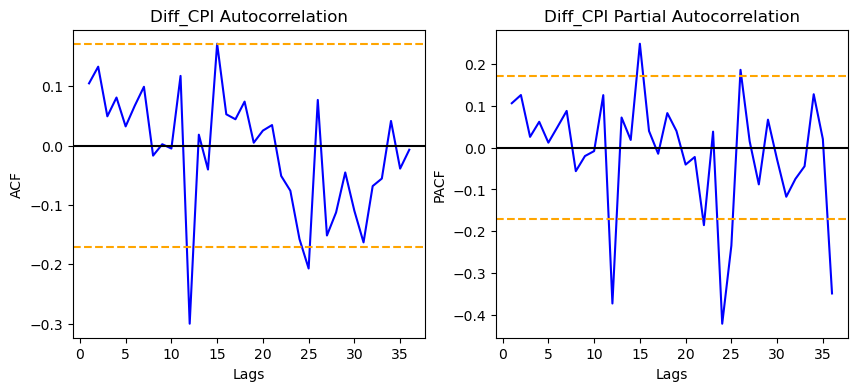

In [145]:
#ACF PACF correlogram

def plot_acf_pacf(series, lags=36, title_suffix=''):
    acf_vals = acf(series, nlags=lags)[1:]
    pacf_vals = pacf(series, nlags=lags)[1:]
    
    # Confidence interval (95% confidence interval)
    confint = 1.96 / np.sqrt(len(series))

    plt.figure(figsize=(10,4))

    # Plot ACF
    plt.subplot(121)
    plt.plot(range(1,lags + 1),acf_vals, linestyle='-', color='blue', label='ACF')
    plt.axhline(y=0, linestyle='-', color='black')
    plt.axhline(y=confint, linestyle='--', color='orange')
    plt.axhline(y=-confint, linestyle='--', color='orange')
    plt.title(f'{title_suffix} Autocorrelation')
    plt.xlabel('Lags')
    plt.ylabel('ACF')
    plt.grid(False)
    
    # Plot PACF
    plt.subplot(122)
    plt.plot(range(1,lags + 1),pacf_vals, linestyle='-', color='blue', label='PACF')
    plt.axhline(y=0, linestyle='-', color='black')
    plt.axhline(y=confint, linestyle='--', color='orange')
    plt.axhline(y=-confint, linestyle='--', color='orange')
    plt.title(f'{title_suffix} Partial Autocorrelation')
    plt.xlabel('Lags')
    plt.ylabel('PACF')
    plt.grid(False)
    
plot_acf_pacf(series, lags=36, title_suffix='Diff_CPI')

From the correlogram, it can be seen that:
* In ACF correlogram, spike appears significantly in **lag 12**, after that, ACF coefficients almost stay within the confident interval.
* In PACF correlogram, spikes appear significantly in **lags 12, 24, 36**. 
I want to look more clearly exceeding values for ACF and PACF.

In [146]:
# ACF and PACF values
acf_vals = acf(series, nlags=28)[1:]

# Confidence interval (approximately 95% confidence interval)
confint = 1.96 / np.sqrt(len(series))

results_ACF= pd.DataFrame({'Lag': range(1, 29),'ACF': acf_vals,'Confidence Interval': confint})

#ACF exceeds the confidence interval
exceeding_ACF = results_ACF[(results_ACF['ACF'].abs() > confint)]

print(exceeding_ACF)

    Lag       ACF  Confidence Interval
11   12 -0.300111             0.171246
14   15  0.171671             0.171246
24   25 -0.207089             0.171246


In [147]:
pacf_vals = pacf(series, nlags=28)[1:]
results_PACF= pd.DataFrame({'Lag': range(1, 29),'PACF': pacf_vals,'Confidence Interval': confint})

#PACF exceeds the confidence interval
exceeding_PACF = results_PACF[ (results_PACF['PACF'].abs() > confint)]

print(exceeding_PACF)

    Lag      PACF  Confidence Interval
11   12 -0.372141             0.171246
14   15  0.247682             0.171246
21   22 -0.185201             0.171246
23   24 -0.420384             0.171246
24   25 -0.234080             0.171246
25   26  0.185396             0.171246


This gives me hint that an Autoregressive Moving Average (ARMA) model, embeding  seasonal effect will be a good fit for my series. Given the nature of monthly CPI data, $SARMA(1,0,0)(0,0,1)_{12}$ model might be suitable.
In which: 
* The first term $(1,0,0)$ refers to the **non-seasonal ARMA component**, which means explaining future values based on its own value lagging 1 period behind. 
* The second term $(0,0,1)$ refers to the **seasonal ARMA component**, with the seasonal period being 12 (because it's monthly data). It means that explanation is based on residuals of the previous 12 months. 

#### Model fitting
First of all, I split my data into training set and test set with the rate approximately 80/20. 
* Training set is from 2010-02-01 to 2019-12-01 (119 observations). The model is first fitted on training set to find a suitable SARIMA model and diagnostics.
* Test set is from 2020-01-01 (12 observations). This sample is used for forecast evaluation. 

In [148]:
# Split the dataset into training and testing sets
train_set = dcpi.loc['2010-02-01':'2019-12-01']
test_set = dcpi.loc['2020-01-01':]

As specified, I will first fit my training set with **$SARMA(1,0,0)(0,0,1)_{12}$** model. `SARIMAX` function from `statsmodels` library supports us to run the model easily. The result is as below:

In [149]:
# Define the model
model = SARIMAX(train_set, 
                order=(1, 0, 0), 
                seasonal_order=(0, 0, 1, 12))

# Fit the model
sarima_fit = model.fit(disp=False)

# Summary of the model
sarima_summary = sarima_fit.summary()
sarima_summary

C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     ITACPALTT01CTGYM   No. Observations:                  119
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                  31.475
Date:                              Tue, 24 Sep 2024   AIC                            -56.951
Time:                                      11:38:09   BIC                            -48.614
Sample:                                  02-01-2010   HQIC                           -53.565
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2128      0.081      2.631      0.009       0.054       0.371
ma.S.L12      -0.8037      0.098     -8.230      0.000      -0.995      -0.612
sigma2         0.0311      0.004      7.541      0.000       0.023       0.039
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.53   Prob(JB):                         0.61
Heteroskedasticity (H):               1.19   Skew:                            -0.22
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From the result, it can be seen that:
* ar.L1 or ar(-1) coefficient = 0.2128, p-value = 0.009, meaning that its own value lagging by 1 period has significantly positive influence on the current value.
* ma.S.L12 or sma(-12) coefficient = -0.8037, p-value = 0.000, meaning that error lagging by 12 periods has seasonally significantly negative influence on the current value.
I got the model equation as below:

$$\Delta CPI_t = \rho_1 \Delta CPI_{t-1} + \theta_1 \Delta u_{t-12} + \epsilon_t$$
Given $\rho_1 = 0.2128$, $\theta_1 = -0.80$
$$\Delta CPI_t = 0.2128 \Delta CPI_{t-1} - 0.80 \Delta u_{t-12} + \epsilon_t$$

#### Residual diagnostics
Now we will check whether there exists serial correlation in the residuals of the model or not. 

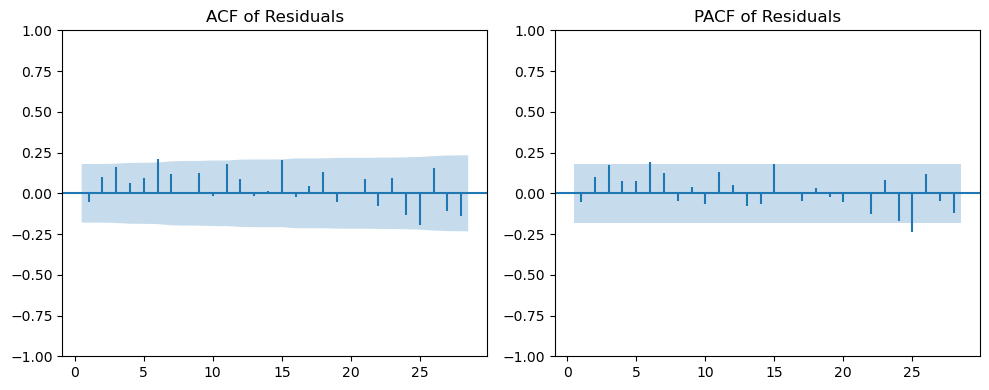

In [150]:
#ACF PACF of model residuals
residuals = sarima_fit.resid
# Plot ACF and PACF of the residuals
plt.figure(figsize=(10, 4))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(residuals, ax=plt.gca(), lags=28,zero=False,marker='')
plt.title('ACF of Residuals')

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(residuals, ax=plt.gca(), lags=28,zero=False,marker='')
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()

From the ACF and PACF plot, it can be said that  ACF and PACF coefficients stay within confident interval. Therefore, there is no longer serial correlation in the residual. The model **$SARMA(1,0,0)(0,0,1)_{12}$** appears to be appropriate for my data. 
To see the performance of my model, I have a look at R-square ($R^2$), showing how many percentage the independent variables explain the dependent variable.
$$R^2=1-\frac{RSS}{TSS}$$ 
in which **RSS** is Residual Sum of Squares, **TSS** is Total Sum of Squares

In [151]:
# Total Sum of Squares (TSS)
tss = ((train_set - train_set.mean()) ** 2).sum()
# Residual Sum of Squares (RSS)
rss = (residuals ** 2).sum()
# R-squared
r_squared = (1 - (rss / tss))*100

r_squared

27.855846309495135

$R^2$ = 27.85%, showing that the independent variables explain 27.85% the dependent variable. 
### 4. Forecasting and forecast evaluation
#### Forecasting
Using the chosen SARIMAX model, now I produce forecast for the test set.

In [152]:
#FORECASTING ON TEST SET
# Initialize a list to store the forecasts
static_forecast = []

# Loop through the test set, predicting each point using the model trained on the training set
for t in range(len(test_set)):
    # Update the model with the next point from the test set and forecast the next value
    model = SARIMAX(train_set, 
                    order=(1, 0, 0), 
                    seasonal_order=(0, 0, 1, 12))
    sarima_fit = model.fit(disp=False)
    
    # Forecast the next point (static forecast)
    forecast = sarima_fit.forecast(steps=1)
    # Append the forecasted value
    static_forecast.append(forecast[0])
    # Update the training set with the actual value from the test set
    train_set = pd.concat([train_set, test_set.iloc[[t]]])

# Convert the list of forecasts to a Series
static_forecast_series = pd.Series(static_forecast, index=test_set.index)

# Combine the actual test set with the static forecasted values for comparison
forecasted_series = pd.DataFrame({
    'Actual': test_set,
    'Forecast': static_forecast_series
})
print(forecasted_series)

C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

              Actual  Forecast
DATE                          
2020-01-01  0.056526 -0.006481
2020-02-01 -0.246767  0.024971
2020-03-01 -0.110413 -0.086054
2020-04-01 -0.059979  0.015322
2020-05-01 -0.313551 -0.018730
2020-06-01 -0.029648 -0.042434
2020-07-01 -0.087185  0.112526
2020-08-01 -0.176527 -0.146535
2020-09-01 -0.044586  0.253622
2020-10-01  0.262860 -0.000700
2020-11-01  0.106614  0.045162
2020-12-01  0.097576  0.039197


#### Forecast evaluation
For forecast evaluation, **Root Mean Squared Forecast Error (RMSFE)** is often calculated. 
$$RMSFE=\sqrt{\frac{1}{R}\sum_{j=1}^{R} \hat{u}_{j+h}^{2}} = \sqrt{\frac{1}{R}\sum_{j=1}^{R}(\Delta{CPI}_{j+h|j}-\hat{\Delta{CPI}}_{j+h|j})^{2}}$$
in which  R is the number of observations in the test set.

In [153]:
# Drop NaN values from both series
test_set_clean = test_set.loc[:'2020-11-01']
static_forecast_series_clean = static_forecast_series.loc[:'2020-11-01']

# RMSFE
rmsfe = np.sqrt(mean_squared_error(test_set_clean, static_forecast_series_clean))

print(f"Root Mean Squared Forecast Error: {rmsfe}")

Root Mean Squared Forecast Error: 0.1844180878562224


RMSFE helps us evaluate the quality of prediction, measuring the average difference between predicted values by the model and the actual values. RMSFE of my forecast model is relatively low at 18.44%.
Let's have a look at the movement of the $\Delta{CPI}_{Actual}$ and $\Delta{CPI}_{Forecast}$

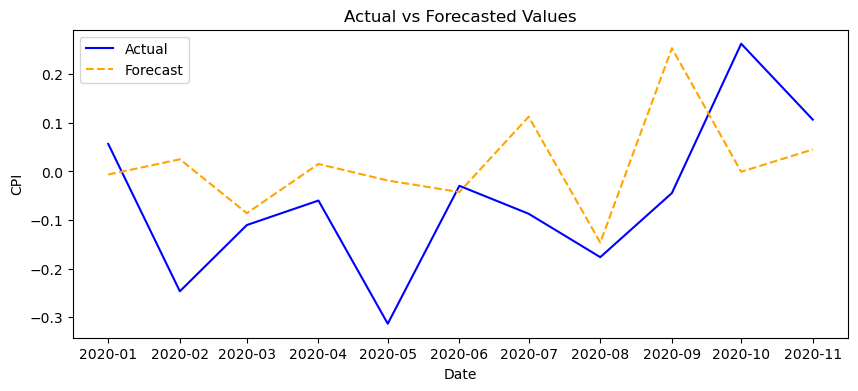

In [154]:
# Plot the actual vs forecasted values
plt.figure(figsize=(10, 4))
plt.plot(test_set_clean.index, test_set_clean, label='Actual', color='blue')
plt.plot(test_set_clean.index, static_forecast_series_clean, label='Forecast', color='orange', linestyle='--')
plt.title('Actual vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(False)
plt.show()

#### Derive forecast for original series
Now my job has not finished yet. Our final destination is to derive forcasts for the original CPI series, not only the differenced CPI series. My approach to derive forecasts for CPI is simple.

$CPI_{T+1} = CPI_{T} + \Delta CPI_{T+1}$  

In which:

$CPI_{T}$ is $CPI_{Forecast}$ at time T *(Notes: for forecast at T+1, it is the last value from the train set)*

$\Delta CPI_{t+1}$ is the $\Delta{CPI}_{Forecast}$ at time t+1 obtained from my model.


In [155]:
train_set_CPI = cpi_data['ITACPALTT01CTGYM'].loc['2010-01-01':'2019-12-01']
test_set_CPI= cpi_data['ITACPALTT01CTGYM'].loc['2020-01-01':]

In [156]:
# Get the last known value of the original CPI from the training set
last_known_cpi = train_set_CPI.iloc[-1]

# Initialize a list to store the forecasted original CPI values
cpi_forecasts = []

# Start with the last known value of the original CPI
current_cpi = last_known_cpi
# Iterate over the forecasted differences and cumulatively add them to the last known CPI value
for forecasted_diff in forecasted_series['Forecast']:
    # Compute the next forecasted original CPI value by adding the forecasted difference
    current_cpi += forecasted_diff
    cpi_forecasts.append(current_cpi)

cpi_forecast_series = pd.Series(cpi_forecasts, index=test_set.index)

# Display the forecasted original CPI values
pd.set_option('display.float_format', '{:.6f}'.format)
cpi_forecast_series

# Compare forecasted CPI values with the actual values from the test set
comparison_df = pd.DataFrame({
    'Forecasted_CPI': cpi_forecast_series,
    'Actual_CPI': test_set_CPI 
})

# Display the comparison
pd.set_option('display.float_format', '{:.6f}'.format)
print(comparison_df)

            Forecasted_CPI  Actual_CPI
DATE                                  
2020-01-01        0.430876    0.493883
2020-02-01        0.455847    0.247116
2020-03-01        0.369793    0.136703
2020-04-01        0.385115    0.076724
2020-05-01        0.366385   -0.236827
2020-06-01        0.323951   -0.266476
2020-07-01        0.436477   -0.353661
2020-08-01        0.289942   -0.530188
2020-09-01        0.543564   -0.574774
2020-10-01        0.542864   -0.311914
2020-11-01        0.588026   -0.205300
2020-12-01        0.627223   -0.107725


To make a more visible visualization of the forecasted and actual CPI in the test set, let's look at the below plot!

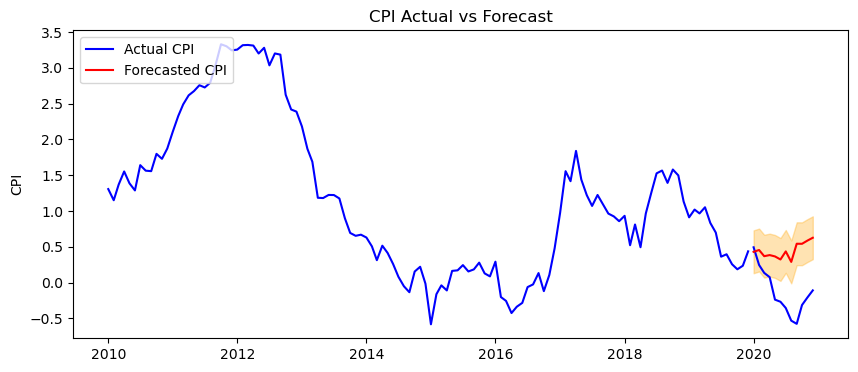

In [157]:
# Standard deviation of the forecasted CPI series
forecast_std = static_forecast_series.std()

# Confidence intervals (± 3 standard deviations)
upper_bound = cpi_forecast_series + 3 * forecast_std
lower_bound = cpi_forecast_series - 3 * forecast_std

# Plot the original CPI values from the training set
plt.figure(figsize=(10, 4))
plt.plot(train_set_CPI.index, train_set_CPI, label='Actual CPI', color='blue')

# Plot the actual CPI values
plt.plot(test_set_CPI.index, test_set_CPI, color='blue')

# Plot the forecasted CPI values
plt.plot(cpi_forecast_series.index, cpi_forecast_series, label='Forecasted CPI', color='red')

# Plot the confidence interval
plt.fill_between(cpi_forecast_series.index, lower_bound, upper_bound, color='orange', alpha=0.3)

plt.title('CPI Actual vs Forecast')
plt.ylabel('CPI')
plt.legend(loc='upper left')
plt.grid(False)

plt.show()

The orange range shows the $\pm$ 3 standard deviation range that CPI may vary in. Generally speaking, the forecasted values from the model can capture main movements of the actual value. However, the increase or decrease trend levels are more intense in the actual data. 
### 5. Conclusion
As we can see from the above plot, the model can only capture the main movement of the actual data, missing the decrease and increase intensity level. It may show that the model works better in stable CPI conditions. 

In more volatile CPI situations, the model may fail to produce a good forecast. In fact, I tried $SARIMA(1,0,0)(0,0,1)_{12}$ on the period 2010 - 2023 and produce forecast for the year 2024, however, the model do not perform well since CPI during this period fluctuated significantly and was influenced heavily by central bank's monetary policy. Probably, with higher fluctuation, for more precise forecast, a more complicated model such as GARCH model should be introduced.